In [1]:
from qiskit_algorithms import AmplificationProblem
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer

## Amplitude amplification
Grover's algorithm uses Hadamard gates to create the uniform superposition of all the states at the beginning of the Grover operator $\mathcal{Q}$. If some information on the good states is available, it might be useful to not start in a uniform superposition but only initialize specific states. This, generalized, version of Grover's algorithm is referred to _Amplitude Amplification_.

To understand _Amplitude Amplificaton_ Let us consider an example with the following marked states: $|010\rangle$ and $|101\rangle$, given below is a quantum circuit `state_preparation` that can prepare the marked states in a superpostion.

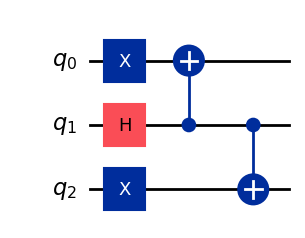

In [2]:
state_preparation = QuantumCircuit(3)

state_preparation.x([0, 2])
state_preparation.h(1)

state_preparation.cx(1, 0)
state_preparation.cx(1, 2)

state_preparation.draw('mpl')

The next step is to then design a circuit `oracle` that applies a phase flip if the state is 'marked' and leave a state untouched if it is not 'marked' (This is similar to the oracle in Grover's search).

$$
    \text{oracle}|x\rangle \mapsto \begin{cases} -|x\rangle, &x \text{  is marked} \\ |x\rangle, &x \text{  is not marked}\end{cases}
$$

This can be achieved by using the `CCZ` gate as shown below

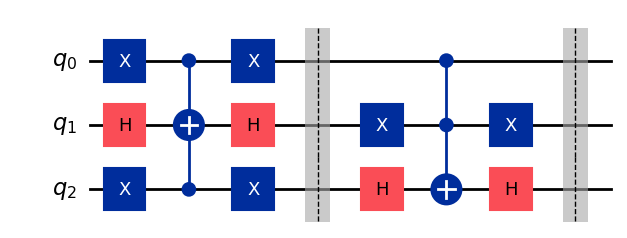

In [3]:
# Step 1: Define an oracle that marks the states |010> and |101> as good states
oracle = QuantumCircuit(3, name="Oracle")

# Mark |001> -> Apply X gates on qubits that should be 0 in the state
oracle.x([0, 2])  # Apply X to flip |0> to |1> where needed
oracle.h(1)
oracle.ccx(0, 2, 1)  # Apply CCZ gate
oracle.h(1)
oracle.x([0, 2])

oracle.barrier()

# Mark |101> -> Apply X gate on qubit 1 because it should be |0>
oracle.x(1) # Apply X to flip |0> to |1> where needed
oracle.h(2)
oracle.ccx(0, 1, 2)  # Apply CCZ gate
oracle.h(2)
oracle.x(1)
oracle.barrier()

oracle.draw("mpl")

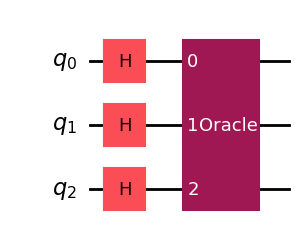

In [4]:
circuit = QuantumCircuit(3)
circuit.h([0, 1, 2])
circuit.append(oracle, [0, 1, 2])
circuit.draw("mpl")

We can see that the `oracle` acting on a full superpostion state applies a phase flip to the 'marked' states as shown in the statevector represention below.

In [5]:
state = Statevector.from_instruction(circuit)
state.draw(output='latex')

<IPython.core.display.Latex object>

The main difference in the _Amplitude Amplification_ algorithm and the Grover's algorithm comes in the final reflection about the initial state (from `state_preparation`). Qiskit's function `AmplificationProblem` provides a way to perform a reflection about the initial state prepared by `state_preparation` rather than a simple reflection about the full superposition state used in _Grover's search_.

To continue we must pass `oracle` (the operation used to apply phase flip to the 'marked' states), and `is_good_state` (list of 'marked' states) to the `AmplificationProblem` as shown below

In [6]:
# we only care about the first two bits being in state 1, thus add both possibilities for the last qubit
problem = AmplificationProblem(
    oracle, is_good_state=["010", "101"]
)

The set of gates seen after the second barrier in the circuit image below is the optimal set of gates to perform the final reflection about our initial state.

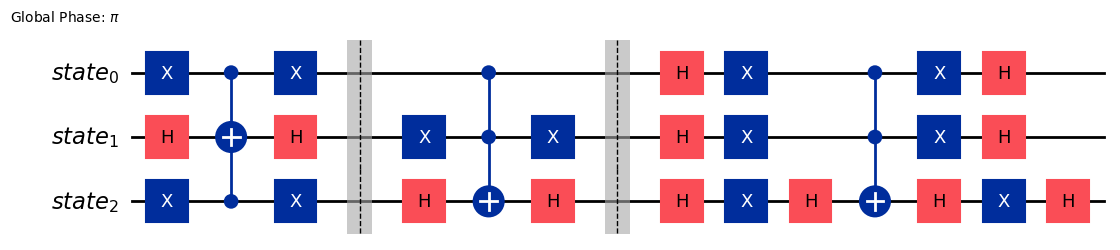

In [7]:
grover_op = problem.grover_operator
grover_op.decompose().draw("mpl")

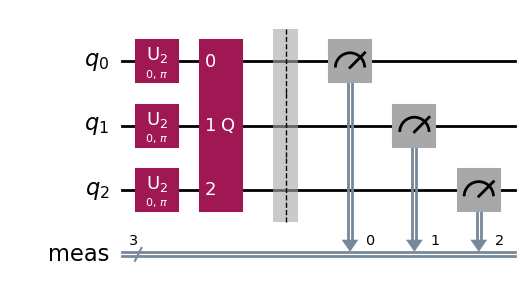

In [8]:
qc = QuantumCircuit(3)

qc.h([0, 1, 2])
qc.append(grover_op, [0, 1, 2])

qc.measure_all()

# qc.measure_all()
qc.decompose().draw("mpl")

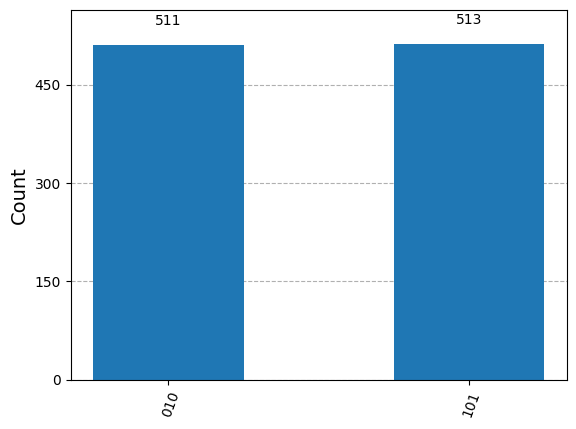

In [9]:
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit).result()
counts = result.get_counts()

plot_histogram(counts)